In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re, string, unicodedata
import nltk
import contractions
import inflect

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import re

from wordcloud import WordCloud, STOPWORDS

import nltk
# import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer


from sklearn import metrics
from sklearn.model_selection import train_test_split
# from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

import scipy

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

import pickle
import time

# Read Train Split and Validation Data

In [2]:
rev_busi = pd.read_csv('filtered_reviews.csv', parse_dates=["date"])

train_df  = pickle.load(open('train_df.pkl', "rb"))
valid_df = pickle.load(open('valid_df.pkl', "rb"))
test_df = pickle.load(open('test_df.pkl', "rb"))
train_valid_df = pickle.load(open('train_valid_df.pkl', "rb"))

In [3]:
train_df = train_df.merge(rev_busi[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
valid_df = valid_df.merge(rev_busi[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
test_df  = test_df.merge(rev_busi[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])
train_valid_df = train_valid_df.merge(rev_busi[["review_id", "user_id", "business_id", "text"]], how = "left", on = ["user_id", "business_id"])

train_df.head(1)

,user_id,business_id,stars,review_id,text
0,--KsuCSkGGvDKTbdK9NvIg,XDlOFRDWQGVjzlvUs1X5Iw,1.0,4Nf86Bb5x5LLQ5Rcj0FQAg,Earned a star for their stellar and vast beer ...


In [4]:
train_df.shape
valid_df.shape
test_df.shape
train_valid_df.shape

(209604, 5)

(25108, 5)

(25108, 5)

(234149, 5)

In [5]:
print("unique users in training set:", train_df["user_id"].nunique())
print("unique businesses in training set:", train_df["business_id"].nunique())
print("unique users in test set:", test_df["user_id"].nunique())
print("unique businesses in test set:", test_df["business_id"].nunique())

unique users in training set: 25420
unique businesses in training set: 4312
unique users in test set: 25108
unique businesses in test set: 4059


# Content-based Model, NLP (Tf-idf)

### - Combine reviews of each business_id as its document 

In [6]:
text_train_df = train_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
len(text_train_df)
text_train_df.head(1)

4312

,business_id,text
0,-0G_6-KFGpCpxTUlVXCMYQ,"For a taco place, this is as good as it gets. ..."


In [7]:
train_valid_df.head(1)
text_train_valid_df = train_valid_df.groupby(["business_id"])["text"].apply(lambda x: x.str.cat()).reset_index()
len(text_train_valid_df)
text_train_valid_df.head(1)

,user_id,business_id,stars,review_id,text
0,--KsuCSkGGvDKTbdK9NvIg,XDlOFRDWQGVjzlvUs1X5Iw,1.0,4Nf86Bb5x5LLQ5Rcj0FQAg,Earned a star for their stellar and vast beer ...


4312

,business_id,text
0,-0G_6-KFGpCpxTUlVXCMYQ,"For a taco place, this is as good as it gets. ..."


### - Generate Wordcloud

<Figure size 1000x1000 with 0 Axes>

(-0.5, 5999.5, 5999.5, -0.5)

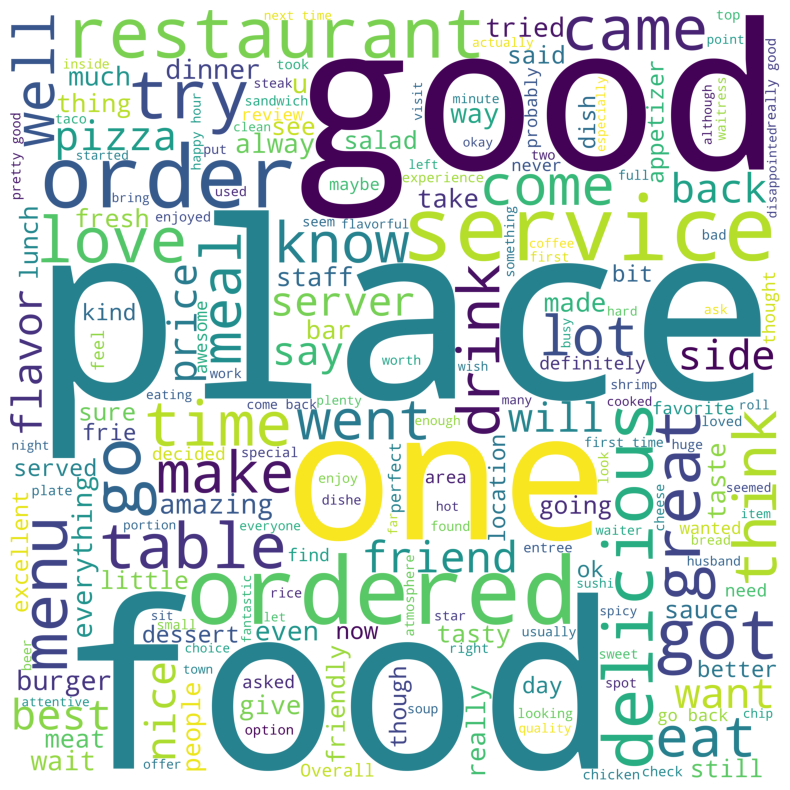

In [8]:
# gather all words together
all_text = ""
all_snippets = text_train_df["text"].values

for snippet in all_snippets:
    all_text += snippet

# plot Wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<Figure size 1000x1000 with 0 Axes>

(-0.5, 5999.5, 5999.5, -0.5)

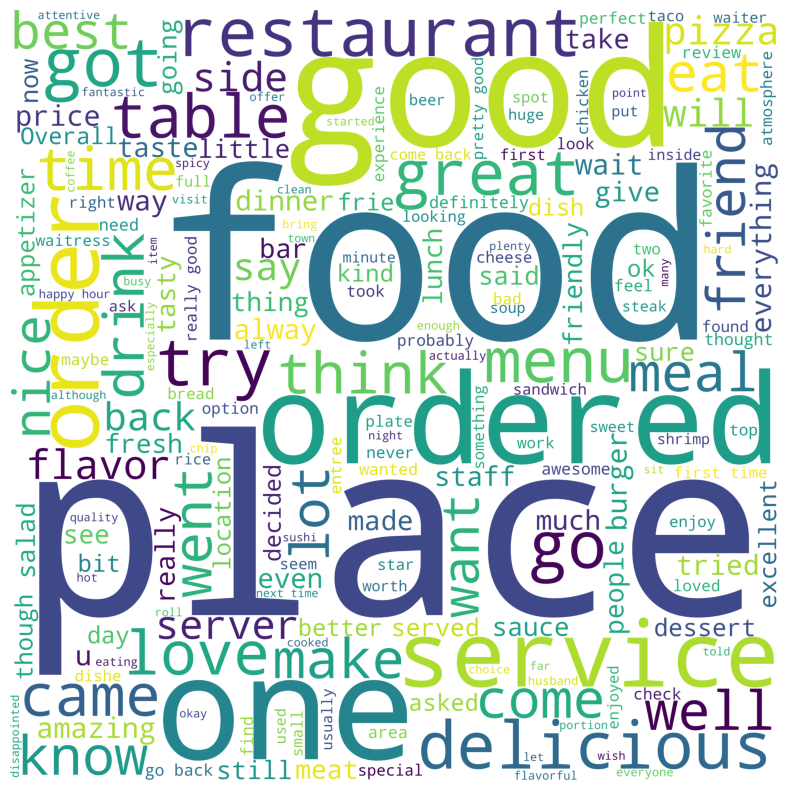

In [9]:
# gather all words together
all_text = ""
all_snippets = text_train_valid_df["text"].values

for snippet in all_snippets:
    all_text += snippet

# plot Wordcloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white',width=6000,height=6000).generate(all_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### - Text Prepocessing

In [10]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
            
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
            
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
            
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
        
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
        
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
        
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    
    return words


In [11]:
def get_processed(sample):
    processed = pd.DataFrame(data=[],columns = ['business_id', 'text'])
    new_texts = []

    for i in range(0, len(sample)):
        business_id = sample['business_id'].iloc[i]
        words = nltk.word_tokenize(sample['text'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'text'])
        new_texts.append(text)
        # processed = processed.append(dfnew,ignore_index = True)
        processed = pd.concat([processed, dfnew], ignore_index=True)

    return processed

In [12]:
# This takes lots of time, 
# You may just read_pickle here after the initial run
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

df_texts_train = get_processed(text_train_df)
df_texts_train.to_pickle('text_train_df.pkl')

df_texts_train_valid = get_processed(text_train_valid_df)
df_texts_train_valid.to_pickle('text_train_valid_df.pkl')



[nltk_data] Downloading package punkt to /home/user3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package stopwords to /home/user3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /home/user3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### - Cosine Similarity

In [13]:
def get_tfidf_matrix(processed):
    '''
    get the Tf-Idf matrix of processed texts for business reviews
    
    '''
    TV = TfidfVectorizer(stop_words = "english")
    processed["text"] = processed["text"].fillna('')
    tfidf_matrix = TV.fit_transform((processed["text"]))
    
    return tfidf_matrix

def get_cos_sim_matrix(tfidf_matrix, n):
    '''
    use truncated SVD to reduce dimensions to n 
    @n: the dimensions to keep
    '''
    SVD = TruncatedSVD(n_components = n , random_state = 42) # 42 is the ultimate answer to everything
    tfidf_truncated = SVD.fit_transform(tfidf_matrix)
    cosine_sim = cosine_similarity(tfidf_truncated, tfidf_truncated)
    
    return cosine_sim


### - Dimension Reduction

<BarContainer object of 4311 artists>

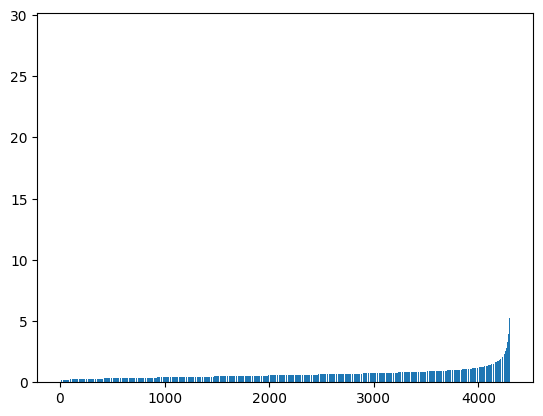

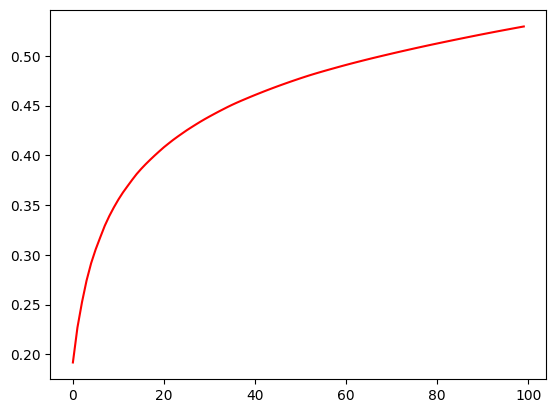

In [39]:
tfidf_matrix = get_tfidf_matrix(df_texts_train)
u, s, vt  = scipy.sparse.linalg.svds(tfidf_matrix, k = tfidf_matrix.shape[0]-1)
plt.bar(range(len(s)),s)
plt.show()

plt.plot(range(len(s))[:100], np.cumsum(sorted((s**2 / sum(s**2)),reverse = True)[:100]), "r" )
plt.show()

<BarContainer object of 70 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

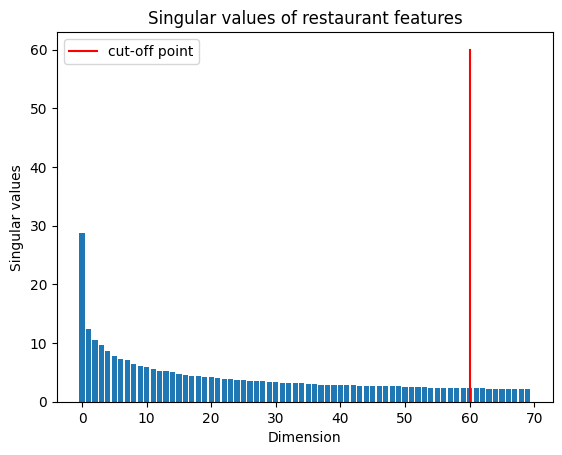

In [42]:
# u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(70),np.sort(s)[::-1][:70])
plt.plot([60 for i in np.linspace(0,60,10)], np.linspace(0,60,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

### - Here we choose n=60 

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

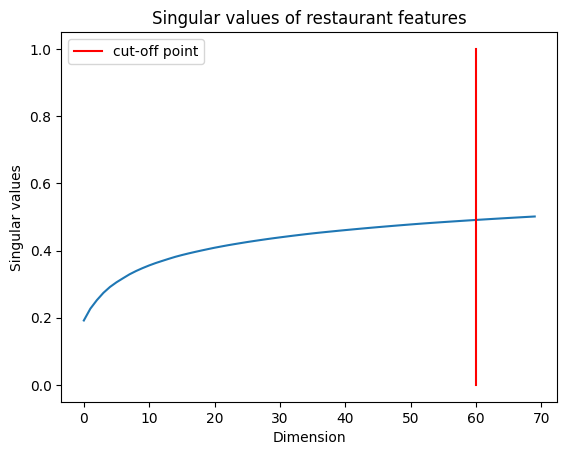

In [41]:
plt.plot(range(70), np.cumsum(np.sort(s)[::-1]**2/np.sum(np.sort(s)[::-1]**2))[:70] )
plt.plot([60 for i in np.linspace(0,1,10)], np.linspace(0,1,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [43]:
### Generate Tf-idf vector space representation, and apply truncated SVD

tfidf_matrix = get_tfidf_matrix(df_texts_train)
cosine_sim = get_cos_sim_matrix(tfidf_matrix, 60)
df_sim = pd.DataFrame(cosine_sim, index=df_texts_train['business_id'].values, columns=df_texts_train['business_id'].values)
df_sim.head(1)
cosine_sim.shape

,-0G_6-KFGpCpxTUlVXCMYQ,-1oygVebK81K8JEPI6H6Lw,-2VYztMXVorktljCdQNPmQ,-3Mc8R5c23FxrxlJn3ivww,-3xX_IfttKjPJ792BOBJ-Q,-4x3pVUUsfWmKEilWKsOZQ,-8luB5pJ7d9UOoiF7wikkw,-AWclhh1_2VnqPylPgBU3g,-Dg2pJigtydnPUUW5XBamQ,-DsC3cvCBEy_FNJ7U-i9zg,...,zl-LqKy7snBF4LKmiVKmNA,zm9aNqkHHtp1f-VT3ZlOZw,zmpRwOqxaajeh2YvAKxLaQ,znlTHyGTSWyqZFYuS0KpmQ,zobY3ws9R2pgbcP0gOImcg,ztnYPn2w0R4lEJL266apzg,ztppjLmFE25wZOQdJKXAuA,zvGNZF827KyzLupKiG4Xtw,zwGvMQ7Nw0VwqLUYDuxRXQ,zz0l4dUf28wzPAaTdGqsSw
-0G_6-KFGpCpxTUlVXCMYQ,1.0,0.071384,0.229507,0.291312,0.344722,0.287923,0.210949,0.197757,0.147038,0.316581,...,0.175341,0.290123,0.330654,0.155166,0.307736,0.347684,0.233147,0.292218,0.49629,0.933974


(4312, 4312)

In [18]:
def get_recommendation_cos(reviews, business_id, user_id, df_sim, k):
    '''get the business_id_array that shows top_k greatest similarity to the specific business_id'''
    user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
    df_user = df_sim.loc[df_sim.index.isin(user_bids), df_sim.columns == business_id]
    df_user_topk = df_user.sort_values(df_user.columns[0], ascending = False).iloc[:k]
    
    return np.array(df_user_topk.index.values)


def predict_rating(reviews, user_id, business_ids):
    '''predict the avg of the user's rating on business in business_ids'''
    scores = reviews.loc[(reviews.user_id == user_id) & (reviews.business_id.isin(business_ids))]["stars"].values
    
    return np.mean(scores)


def get_results_cos(reviews, reviews_test, business_id, user_id, df_sim, k):
    '''
    prediction on the business_id：avg the ratings on top_k business that shows similarity to the business_id
    actual on the business_id: the true rating 
    '''
    actual = reviews_test.loc[(reviews_test.user_id==user_id) & (reviews_test.business_id==business_id)]['stars'].values[0]
    business_ids = get_recommendation_cos(reviews, business_id, user_id, df_sim, k)
    prediction = predict_rating(reviews, user_id, business_ids)
    
    return actual, prediction

def get_review_processed(processed, reviews):
    reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                                                       .reset_index()\
                                                       .drop(columns=['index'])
    return reviews_processed

In [19]:
reviews_processed = get_review_processed(df_texts_train, train_df)
reviews_processed.head()

,user_id,business_id,stars,review_id,text
0,--KsuCSkGGvDKTbdK9NvIg,XDlOFRDWQGVjzlvUs1X5Iw,1.0,4Nf86Bb5x5LLQ5Rcj0FQAg,Earned a star for their stellar and vast beer ...
1,--KsuCSkGGvDKTbdK9NvIg,vKTTtmv9-xoM9IecE68DpA,2.0,-MtjSZJ68Gj_xv329woQaQ,*Don't sit at the bar. Good food but consiste...
2,--_H9j6ggxvqhh9nPofZwg,hc0KmC42EzjXbC83eMIDMg,4.0,4xwQsFEy9m49jIMBcrPXsw,If you are a vegetarian you need to make sure ...
3,--_H9j6ggxvqhh9nPofZwg,crjRqGzxe6-MM4ylqlSfmw,4.0,N8kBk18xfzifwrwMS67QuA,It has been a very long time since I last visi...
4,--_r6E98SNIrGU7weyNxbw,36_FvBjdMXC949XVYDUb6A,5.0,uOfdyP0IB_bAjBkdj7qdNg,I went here during restaurant week and just lo...


In [20]:
def CB_predict(reviews, reviews_test, df_sim, k = 5):
    '''
    based on test_df 
    get a dataframe with each user on each business's true ratings and prediction ratings
    @k: int, top k similar businesses
    '''
    user_id_sample = reviews_test['user_id'].values
    busi_id_sample = reviews_test['business_id'].values
    
    actual = []
    predictions = []
    
    for i in range(len(reviews_test)):
        try:
            act, pred = get_results_cos(reviews, reviews_test, busi_id_sample[i], user_id_sample[i], df_sim, k)
            actual.append(act)
            predictions.append(pred)
            
        except:
            actual.append(np.nan)
            predictions.append(np.nan)
            
    return pd.DataFrame({"user_id": user_id_sample,
                         "business_id": busi_id_sample,
                         "true_ratings": actual,
                         "prediction_ratings":  predictions                        
                        })

### - Tuning parameters k

time elapsed: (seconds)
6849.61


<Axes: xlabel='ks'>

optimal k (nearest neighbors):
   ks sample_size      rmse       mae
4  45       25108  1.197348  0.956583


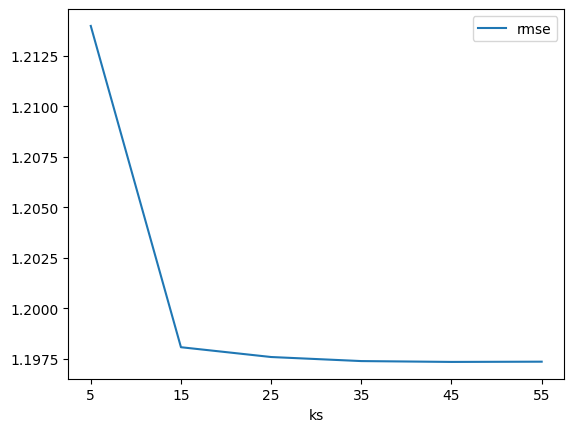

In [21]:
# # run this may take 6849.61 seconds

t0 = time.time()
df_pred_results = pd.DataFrame(columns= ["ks", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5, 15, 25, 35, 45, 55]

for sample_size in sample_sizes:
    for k in ks:
        valid = CB_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_sim, k)
        rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
        dfnew = pd.DataFrame({"ks": k, "sample_size": sample_size, "rmse": rmse, "mae": mae}, index=[0])
        # df_pred_results = df_pred_results.append(dfnew, ignore_index = True)
        df_pred_results = pd.concat([df_pred_results, dfnew], ignore_index=True)

t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results[df_pred_results["sample_size"] == sample_size].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),])

# df_pred_results.to_csv("Content_Based_Filtering_Cosine_Evaluation.csv",index = False)

In [22]:
df_pred_results.to_csv("CBF_Cosine_Evaluation.csv",index = False)

(array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
 [Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40'),
  Text(45.0, 0, '45'),
  Text(50.0, 0, '50'),
  Text(55.0, 0, '55'),
  Text(60.0, 0, '60')])

(array([1.4335 , 1.43375, 1.434  , 1.43425, 1.4345 , 1.43475, 1.435  ,
        1.43525, 1.4355 ]),
 [Text(0, 1.4335, '1.43350'),
  Text(0, 1.4337499999999999, '1.43375'),
  Text(0, 1.434, '1.43400'),
  Text(0, 1.43425, '1.43425'),
  Text(0, 1.4344999999999999, '1.43450'),
  Text(0, 1.43475, '1.43475'),
  Text(0, 1.435, '1.43500'),
  Text(0, 1.43525, '1.43525'),
  Text(0, 1.4355, '1.43550')])

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Tf-idf): k vs MSE')

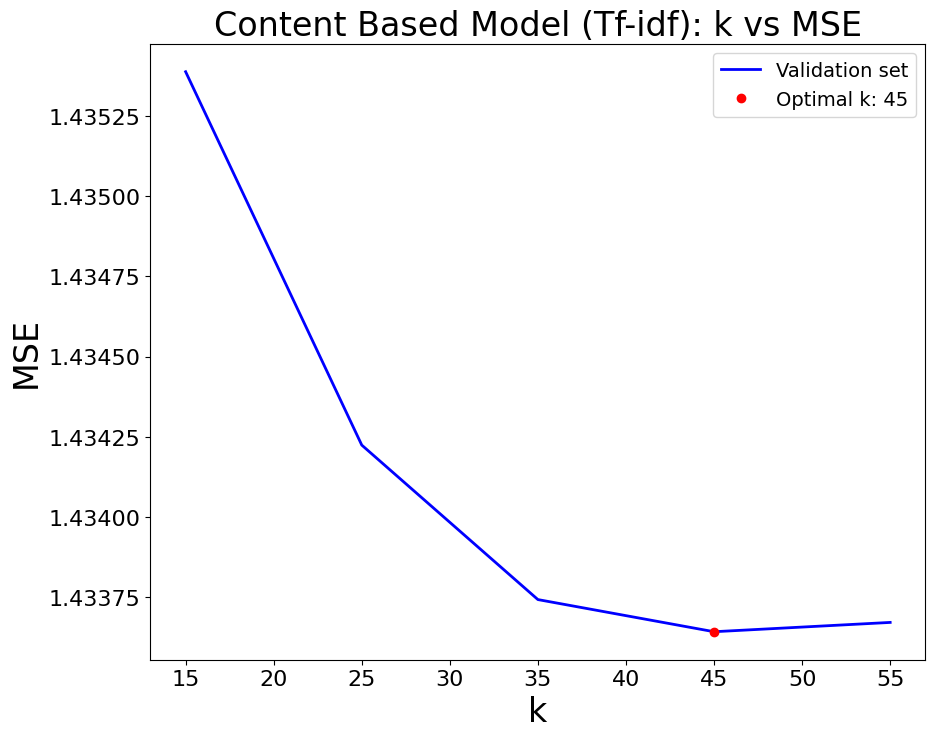

In [23]:
fig, ax = plt.subplots(figsize=(10,8))

optimal = df_pred_results.loc[df_pred_results["rmse"] == np.min(df_pred_results.rmse),]
# plt.figure()
plt.plot(df_pred_results["ks"][1:], np.round(df_pred_results["rmse"]**2,10)[1:], 
         label = "Validation set", linewidth = 2, color ="blue")
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(optimal["ks"], np.round(optimal["rmse"]**2,10), "ro", label = "Optimal k: {}".format(45))
plt.legend(loc = "best", fontsize = 14)
plt.xlabel("k", fontsize = 24)
plt.ylabel("MSE", fontsize = 24)
plt.title("Content Based Model (Tf-idf): k vs MSE",fontsize=24)

In [24]:
### Prediction using the tuned parameters

t0 = time.time()
k = 45

valid = CB_predict(train_df, valid_df, df_sim, k)
mse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
mae =  mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))
print(mse)
valid.to_csv("Predictions_CB_tfidf.csv", index = False)


time elapsed: (seconds)
1074.939
1.4336431090513135


# Content-Based Filtering (Business Attributes)

### This model leverages business non-reviews features to generate the similarity matrix

### We have done feature engineering in the previous step

In [25]:
bus_df_subset = pd.read_csv("business_subset_cleaned.csv", index_col= "business_id")
bus_df_subset.head(1)

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,GoodForKids,RestaurantsReservations,RestaurantsTableService,HappyHour,...,Ambience_upscale,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
MTSW4McQd7CbVtyjqoe9mw,0.637723,0.925908,0.382081,-0.469568,1,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1


In [26]:
len(bus_df_subset.columns)

37

In [27]:
bus_df_subset.head(1)
bus_df_subset.shape

,latitude,longitude,stars,review_count,is_open,RestaurantsGoodForGroups,GoodForKids,RestaurantsReservations,RestaurantsTableService,HappyHour,...,Ambience_upscale,Parking,music,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
business_id,,,,,,,,,,,,,,,,,,,,,
MTSW4McQd7CbVtyjqoe9mw,0.637723,0.925908,0.382081,-0.469568,1,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1


(4312, 37)

### Calculate truncated SVD and use reduced data to calculate similarity

<BarContainer object of 37 artists>

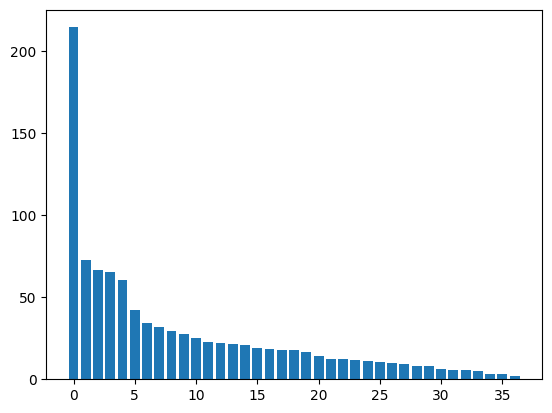

In [28]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.show()


<BarContainer object of 37 artists>

Text(0.5, 1.0, 'Singular values of restaurant features')

Text(0.5, 0, 'Dimension')

Text(0, 0.5, 'Singular values')

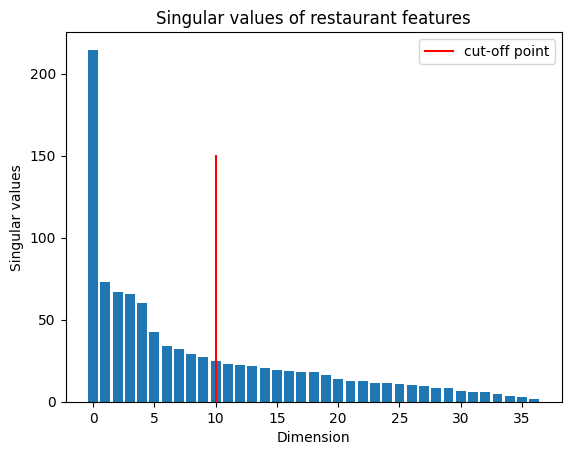

In [29]:
u, s, vt  = np.linalg.svd(bus_df_subset.iloc[:,:])
plt.bar(range(len(s)),s)
plt.plot([10 for i in np.linspace(0,150,10)], np.linspace(0,150,10),"r", label = "cut-off point")
plt.title("Singular values of restaurant features")
plt.xlabel("Dimension")
plt.ylabel("Singular values")
plt.legend(loc = "best")
plt.show()

In [30]:
np.cumsum(s**2/np.sum(s**2))[:10]

array([0.61479649, 0.68577353, 0.74527371, 0.80245617, 0.8511491 ,
       0.87504249, 0.89066064, 0.9042543 , 0.9157726 , 0.92583226])

### Choose top 10 singular values based on the above chart

In [31]:
def get_buscosine_sim(business,n_components):
    SVD = TruncatedSVD(n_components = n_components , random_state = 42) 
    bus_truncated = SVD.fit_transform(business)
    
    cosine_sim = cosine_similarity(bus_truncated, bus_truncated)
    return cosine_sim

### * the two types of similarity measures yield materially different distributions, to be tested for which is better

In [32]:
bus_cos_sim = get_buscosine_sim(bus_df_subset, 10)
df_cos_sim  = pd.DataFrame(bus_cos_sim, index= bus_df_subset.index.values, columns=bus_df_subset.index.values)
bus_cos_sim.shape

(4312, 4312)

### Tuning optimal values for k (neighbors), also test the two similarity measures

time elapsed: (seconds)
6960.82


<Axes: xlabel='ks'>

optimal k (nearest neighbors):
   ks similarity sample_size      rmse       mae
1  15        cos       25108  1.195651  0.912834


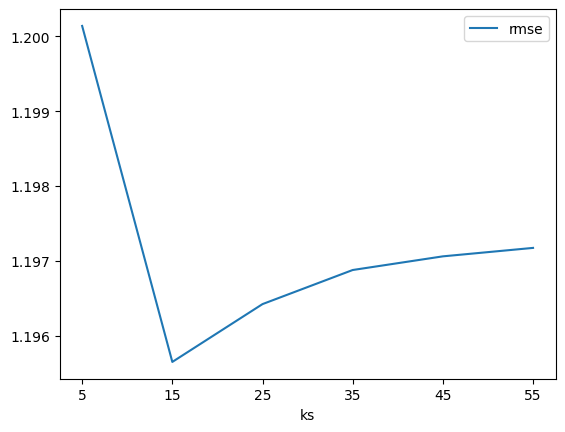

In [33]:
t0 = time.time()
df_pred_results_bus = pd.DataFrame(columns= ["ks", "similarity", "sample_size", "rmse", "mae"])
sample_sizes = [len(valid_df)]
ks = [5,15,25, 35, 45, 55]
similarity = ["cos"]

for sim in similarity:
    if sim == "eucl":
        df_bus_sim = df_eucl_sim.copy()
    else:
        df_bus_sim = df_cos_sim.copy()
    
    for sample_size in sample_sizes:
        for k in ks:
            valid = CB_predict(train_df, valid_df.sample(n = sample_size, random_state = 12), df_bus_sim, k)
            rmse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)**0.5
            mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
            dfnew = pd.DataFrame({"ks": k, "similarity": sim,  "sample_size": sample_size,
                                  "rmse": rmse, "mae": mae}, index = [0])
            # df_pred_results_bus = df_pred_results_bus.append(, ignore_index = True)
            df_pred_results_bus = pd.concat([df_pred_results_bus, dfnew], ignore_index=True)

t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))

df_pred_results_bus[(df_pred_results_bus["sample_size"] == sample_size) &(df_pred_results_bus["similarity"] == "cos")].plot("ks", "rmse")
print("optimal k (nearest neighbors):")
print(df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse) ,])

df_pred_results_bus.to_csv("CBF_Bus_nonNLP_Evaluation.csv",index = False)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60')])

(array([1.428, 1.43 , 1.432, 1.434, 1.436, 1.438, 1.44 , 1.442]),
 [Text(0, 1.428, '1.428'),
  Text(0, 1.43, '1.430'),
  Text(0, 1.432, '1.432'),
  Text(0, 1.434, '1.434'),
  Text(0, 1.436, '1.436'),
  Text(0, 1.438, '1.438'),
  Text(0, 1.44, '1.440'),
  Text(0, 1.442, '1.442')])

Text(0.5, 0, 'k')

Text(0, 0.5, 'MSE')

Text(0.5, 1.0, 'Content Based Model (Restaurant Attribute): k vs MSE')

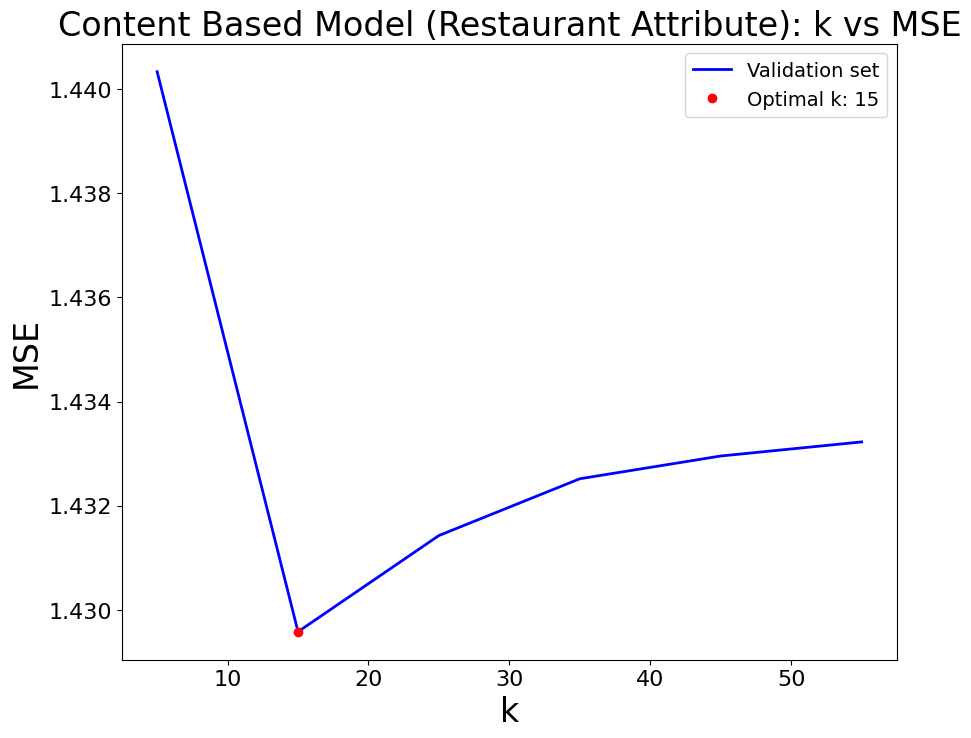

In [34]:
fig, ax = plt.subplots(figsize=(10,8))

optimal = df_pred_results_bus.loc[df_pred_results_bus["rmse"] == np.min(df_pred_results_bus.rmse),]

plt.plot(df_pred_results_bus["ks"], np.round(df_pred_results_bus["rmse"]**2,10), 
         label = "Validation set", linewidth = 2, color ="blue")
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(optimal["ks"], np.round(optimal["rmse"]**2,10), "ro", label = "Optimal k: {}".format(15))
plt.legend(loc = "best", fontsize = 14)
plt.xlabel("k", fontsize = 24)
plt.ylabel("MSE", fontsize = 24)
plt.title("Content Based Model (Restaurant Attribute): k vs MSE",fontsize=24)

In [35]:
### Generate predictions using optimized parameters

t0 = time.time()
k = 15
    
valid = CB_predict(train_df, valid_df, df_cos_sim, k)
mse = mean_squared_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)
mae = mean_absolute_error(valid.dropna().prediction_ratings, valid.dropna().true_ratings)

t1 = time.time()
print("time elapsed: (seconds)")
print(np.round(t1 - t0,3))
print(mse)

valid.to_csv("Predictions_CB_bus.csv",index = False)

time elapsed: (seconds)
1024.999
1.429582187631011
